# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [1]:
!pip install nltk
!pip install subword_nmt


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: C:\Users\playi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: C:\Users\playi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w',encoding = 'utf8') as f_src,  open('train.ru', 'w',encoding = 'utf8') as f_dst:
    for line in open('data.txt',encoding = 'utf8'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang,encoding = 'utf8'), open('bpe_rules.' + lang, 'w',encoding = 'utf8'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang,encoding = 'utf8'))
    
    with open('train.bpe.' + lang, 'w',encoding = 'utf8') as f_out:
        for line in open('train.' + lang,encoding = 'utf8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:10<00:00, 773.36it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [2]:
import numpy as np

In [3]:
data_inp = np.array(open('./train.bpe.ru',encoding = 'utf8').read().split('\n'))
data_out = np.array(open('./train.bpe.en',encoding = 'utf8').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(100,103):
    print('inp:', train_inp[i+2])
    print('out:', train_out[i+3], end='\n\n')

inp: дом с проживанием в семье lake front расположен в городе канди , в 300 метрах от больницы лей@@ к@@ сайд ад@@ венти@@ ст . во всех зонах работает бесплатный wi - fi .
out: g@@ jer@@ r@@ il@@ d nor@@ d@@ strand beach , trout fishing opportunities and fo@@ s@@ si@@ l hunting on the cliffs are all 4 km from the hostel .

inp: в 4 км от хостела расположены пляж г@@ ьер@@ ри@@ лд нор@@ д@@ стра@@ н@@ д , место ловли л@@ ос@@ о@@ ся , а также ска@@ лы , где можно заняться по@@ и@@ ском и@@ ско@@ па@@ ем@@ ых .
out: at wind@@ haven hotel you will find a 24 - hour front desk , a garden and a terrace .

inp: в отеле win@@ d@@ ha@@ ven имеется круглосуточная стойка регистрации , сад и терраса .
out: just a 15 - minute walk from kar@@ f@@ as beach , vila cl@@ io is located in kam@@ bos , on the island of ch@@ ios . it is situated in the area of f@@ rag@@ kov@@ o@@ uni medieval village and offers self - catering accommodation and a garden with a l@@ ily pond .



In [4]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [5]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


In [6]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = train_inp[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['дом для отпуска la cas@@ ita del mar находится в очаровательном старом городе си@@ т@@ ж@@ еса , в 50 метрах от набережной .'
 'для желающих могут быть организованы различные дополнитель@@ ные услуги , в том числе сеансы массажа . по прибытии гостям предлагается приветственный пода@@ рок : св@@ еч@@ и и вино .'
 'каждый номер располагает собственной ванной комнатой с ванной или душем .'
 'в этом отеле с прекрасным видом на горы имеется зона бесплатного wi - fi и бесплатная парковка .'
 'билеты можно приобрести на территории отеля .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2943, 2914, 5244,  824,  368,  769,  462,  889, 4722, 2140, 5279,
         6766, 2666, 6469, 6902, 3204, 3175,   25, 2140,  102, 4488, 5161, 4655,
           29,    1,    1,    1,    1,    1,    1,    1],
        [   0, 2914, 3221, 4543, 2134, 5099, 6058, 2968, 4881, 7302,   25, 2140,
         7070, 7720, 6419, 4383,   29, 5528, 5823, 2703, 5785, 5826, 5541, 6250,
          145, 6378, 3200, 3442, 344

In [7]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines_out = train_out[5:10]
batch_ids_out = out_voc.to_matrix(batch_lines_out)
batch_lines_restored_out = out_voc.to_lines(batch_ids_out)

print("lines")
print(batch_lines_out)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids_out)
print("\nback to words")
print(batch_lines_restored_out)

lines
["la cas@@ ita del mar is a located in sitges ' charming old town , 50 metres from the seafront promenade ."
 'a range of extras can be arranged including massages and wine and cand@@ les on arrival .'
 'each room has a private bathroom with a bathtub or shower .'
 'offering beautiful mountain views , it has a free wi - fi zone and free parking .'
 'tickets are available on site .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 3763, 1352, 3463, 1911, 4142, 3434,  190, 3975, 3329, 6021,   10,
         1469, 4676, 6745,   19,  124, 4273, 2690, 6592, 5821, 5214,   23,    1],
        [   0,  190, 5349, 4657, 2452, 1294,  929,  657, 3339, 4191,  503, 7340,
          503, 1302, 3871, 4698,  662,   23,    1,    1,    1,    1,    1,    1],
        [   0, 2145, 5597, 3049,  190, 5197,  915, 7354,  190,  918, 4734, 5954,
           23,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   0, 4662,  941, 4419, 7128,   19, 3461, 3049,  190, 2667, 7316,   21,
    

## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device = 'cpu'

In [10]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state,out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        tokens = self.emb_out(prev_tokens)
        prev_state = prev_state[0]
        new_dec_state = self.dec0(tokens, prev_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, new_logits = self.decode_step(state,out_tokens[:,i])
            logits_sequence.append(new_logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [11]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
# print(logits_seq2)
print(logits_seq2.shape)
assert logits_seq2.shape == logits_seq.shape

torch.Size([5, 7, 7801])


In [12]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
apa strol@@ résidence romana lunches pol@@ h@@ tera col@@ way izi izi izi izi doors riding aero@@ monuments entertainment zan@@ homest@@ hama â@@ bron@@ cave
apa aero@@ 80 den@@ cht salem salem pret@@ pret@@ far@@ travell@@ hama či@@ plateau ares brest gest bott@@ discounted castel@@ preserved torre 160 mann@@ ran
apa strol@@ résidence romana lunches pol@@ h@@ tera col@@ way izi izi izi izi doors riding aero@@ monuments entertainment zan@@ homest@@ hama â@@ bron@@ cave


In [13]:
torch.sum(model.out_voc.compute_mask(dummy_inp_tokens))

tensor(31)

### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [14]:
def loss_function(model, inp, out,**flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out).to(device) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32).to(device)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токеноы на всех шагах
    logprobs_seq = -torch.nn.functional.log_softmax(logits_seq,dim=-1).to(device)# [batch_size, out_len, num_tokens]
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq* targets_1hot).sum(dim=-1)[mask].to(device)# [batch_size, out_len]
    # нужно обойтись только векторными операциями без for
    # cross-entropy по всем токенам где mask == True
    return torch.sum(logp_out)/torch.sum(mask) # тут должен получиться скаляр!

In [16]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5614, grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [15]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 25000


In [17]:
from torch.utils.data import Dataset, DataLoader

class NlpDataset_tr(Dataset):
    def __init__(self, inp_voc,out_voc,inp, out):
        self.inp_tokens = inp_voc.to_matrix(inp)
        self.out_tokens = out_voc.to_matrix(out)

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        return self.inp_tokens[idx],self.out_tokens[idx]

    def __len__(self):
        return len(self.inp_tokens)

class NlpDataset_dev(Dataset):
    def __init__(self,inp, out):
        self.inp_tokens = inp
        self.out_tokens = out

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        return self.inp_tokens[idx],self.out_tokens[idx]

    def __len__(self):
        return len(self.inp_tokens)


In [ ]:
train_set = NlpDataset_tr(inp_voc,out_voc,train_inp, train_out)
dev_set = NlpDataset_dev(dev_inp, dev_out)
train_loader = DataLoader(
    dataset=train_set,
    batch_size= batch_size,
    shuffle=True)

dev_loader = DataLoader(
    dataset=dev_set,
    batch_size=batch_size, 
    shuffle=False
    )

In [ ]:
epoches = int(num_iter/len(train_loader))

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

In [ ]:
for epoch in range(epoches): 
    model = model.train()
    for data in tqdm(train_loader,desc = 'Эпоха '+str(epoch)):
        inp, out = data[0].to(device),data[1].to(device)
        loss = loss_function(model,inp,out)
#         print(metrics['train_loss'])
        loss.backward() 
        opt.step()
        opt.zero_grad()
        metrics['train_loss'].append(loss.cpu().detach().numpy())
#         print(metrics['train_loss'])
#         wandb.log({
#         "Epoch": epoch,
#         "Mean Train Loss": sum(loss_tr)/len(loss_tr),
#         "Train Acc": Acur(pred_tr,targ_tr),
#         "Learning rate": scheduler.get_last_lr()[0]})
    for data in tqdm(dev_loader,desc ='Эпоха валидация'+str(epoch)):
        inp, out = data[0],data[1]
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states
        bleu = compute_bleu(model,inp,out)
        metrics['dev_bleu'].append(bleu)
    clear_output()
    fig = plt.figure(figsize=(16,20))
    ax1,ax2 = fig.subplots(2,1)
    ax1.plot(metrics['train_loss'])
    ax1.grid()
    ax1.set_title('Train Loss')
    ax2.plot(metrics['dev_bleu'],color = 'orange')
    ax2.grid()
    ax2.set_title('BLEU')
    plt.show(block=True)

In [ ]:
metrics['dev_bleu']

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [25]:
lay = nn.Parameter(torch.FloatTensor(10,12))
print(lay.shape)
print(lay.unsqueeze(1).shape)

torch.Size([10, 12])
torch.Size([10, 1, 12])


In [ ]:
r = torch.tensor([[[1,2,3],[3,4,3]],[[10,12,11],[13,14,21]]]).float()
print(r.shape)
print(r.dtype)

In [ ]:
lin = torch.nn.Linear(3,10)
a = lin(r)
print(a.shape)

In [ ]:
r = torch.tensor([[1,2],[3,4]])
print(r.shape)
r = r.view(2,1,-1)
print(r)
print(r.shape)
r=r.expand(-1,2,2)
print(r)
print(r.shape)
print(r[:,0,:])

In [137]:
encod = torch.tensor([[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]])
print(encod)
print(encod.shape)
prob = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[1,2,1]])
print(prob)
print(prob.shape)

tensor([[[1, 2],
         [1, 2],
         [1, 2]],

        [[1, 2],
         [1, 2],
         [1, 2]],

        [[1, 2],
         [1, 2],
         [1, 2]],

        [[1, 2],
         [1, 2],
         [1, 2]]])
torch.Size([4, 3, 2])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
        [1, 2, 1]])
torch.Size([4, 3])


In [138]:
prob = prob.view(4,3,1).expand(4,3,2)
print(prob)

tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[4, 4],
         [5, 5],
         [6, 6]],

        [[7, 7],
         [8, 8],
         [9, 9]],

        [[1, 1],
         [2, 2],
         [1, 1]]])


In [140]:
a = prob*encod
print(a.shape)
print(a)

torch.Size([4, 3, 2])
tensor([[[ 1,  2],
         [ 2,  4],
         [ 3,  6]],

        [[ 4,  8],
         [ 5, 10],
         [ 6, 12]],

        [[ 7, 14],
         [ 8, 16],
         [ 9, 18]],

        [[ 1,  2],
         [ 2,  4],
         [ 1,  2]]])


In [142]:
print(a.sum(dim=1).shape)

torch.Size([4, 2])


In [ ]:
b= encod[:,0,:]
print(b)
print(b.shape)

In [ ]:
c= prob[:,0].view(-1,1)
print(c)
print(c.shape)

In [ ]:
a = b*c
print(a)
print(a.shape)

In [18]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.attn = torch.nn.Sequential(torch.nn.Tanh(),  
                                        torch.nn.Linear(hid_size,1)
                                       )
        self.lin_e = torch.nn.Linear(enc_size,hid_size)
        self.lin_d = torch.nn.Linear(dec_size,hid_size)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
#         print(enc)
#         print('enc.shape',enc.shape)
#         print(dec.shape)
        log_size = enc.shape[0:2]
        logits= torch.empty(log_size).to(device)
        dec_lay = dec.view(-1,1,self.enc_size).expand(-1,log_size[1],self.enc_size)
 
        # считаем логиты
        for i in range(enc.shape[1]):
            x = enc[:,i,:]
            logits[:,i] =self.attn(self.lin_e(x)+self.lin_d(dec)).view(-1)

        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask==0,-1e9,logits)

        # Примените softmax
        probs = torch.nn.functional.log_softmax(logits.view(log_size[0],-1),
                                                dim=1).view(log_size[0],log_size[1],1).expand(log_size[0],
                                                                                              log_size[1],self.hid_size)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        
        attn = enc[:,0,:]*probs[:,0].view(-1,1)
#         print('en',enc[:,0,:].shape)
#         print('prob',probs[:,0].shape)
        for i in range(1,enc.shape[1]):
            attn += enc[:,i,:]*probs[:,i].view(-1,1)
#         print('attn.shape',attn.shape)
        return attn, probs

In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.attn = torch.nn.Sequential(torch.nn.Tanh(),  
                                        torch.nn.Linear(hid_size,1)
                                       )
        self.lin_e = torch.nn.Linear(enc_size,hid_size)
        self.lin_d = torch.nn.Linear(dec_size,hid_size)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
#         print(enc)
#         print('enc.shape',enc.shape)
#         print(dec.shape)
        log_size = enc.shape[0:2]
#         logits= torch.empty(log_size).to(device)
        dec_lay = dec.view(-1,1,self.enc_size).expand(-1,log_size[1],self.enc_size)
        print('dec_lay',dec_lay.shape)
        print('enc',enc.shape)
 
        # считаем логиты
        logits =self.attn(self.lin_e(enc)+self.lin_d(dec_lay))
        print('logits',logits.shape)
        print('mask',inp_mask.shape)
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask==0,-1e9,logits.view(log_size[0],-1))
        print('logits',logits.shape)
        # Примените softmax
        probs = torch.nn.functional.log_softmax(logits,dim=1)
        print('probs',probs.shape)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        
        attn = enc[:,0,:]*probs[:,0].view(-1,1)
#         print('en',enc[:,0,:].shape)
#         print('prob',probs[:,0].shape)
        for i in range(1,enc.shape[1]):
            attn += enc[:,i,:]*probs[:,i].view(-1,1)
#         print('attn.shape',attn.shape)
        return attn, probs

In [20]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.attn = torch.nn.Sequential(torch.nn.Tanh(),  
                                        torch.nn.Linear(hid_size,1)
                                       )
        self.lin_e = torch.nn.Linear(enc_size,hid_size)
        self.lin_d = torch.nn.Linear(dec_size,hid_size)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
#         print(enc)
#         print('enc.shape',enc.shape)
#         print(dec.shape)
        log_size = enc.shape[0:2]
#         logits= torch.empty(log_size).to(device)
#         print('dec',dec.shape)
 
        dec_lay = dec.view(-1,1,self.enc_size).expand(-1,log_size[1],self.enc_size)
#         print('dec_lay',dec_lay.shape)
#         print('enc',enc.shape)
 
        # считаем логиты
        logits =self.attn(self.lin_e(enc)+self.lin_d(dec_lay))
#         print('logits',logits.shape)
#         print('mask',inp_mask.shape)
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask==0,-1e9,logits.view(log_size[0],-1))
#         print('logits',logits.shape)
        # Примените softmax
        probs = torch.nn.functional.log_softmax(logits.view(log_size[0],-1),
                                                dim=1).view(log_size[0],log_size[1],1).expand(log_size[0],
                                                                                              log_size[1],self.hid_size)
#         print('probs',probs.shape)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        
        attn = probs*enc
        attn = attn.sum(dim=1)
#         print('attn.shape',attn.shape)
        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [181]:
class AttentiveModel(BaseModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
#         <YOUR CODE: initialize layers>
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
        self.attn = AttentionLayer('Encod_decod',hid_size, hid_size, hid_size)
        
        
    def encode(self, inp, **flags):
        
        # делаем encode
#        print('inp',inp.shape)
        inp_emb = self.emb_inp(inp)
#         print('inp_emb',inp.shape)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but] = self.enc0(inp_emb)
#         print(enc_seq.shape)
#         print(len(enc_seq))
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        # ^-- shape: [batch_size, hid_size]
#         lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
#         print(len(lengths))
#         last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
#         print(last_state.shape)
#         print(last_state_but.shape)
        inp_mask = self.inp_voc.compute_mask(inp).to(device)
#         print(inp)
#         print(inp_mask)
        
    
#         dec_start = self.dec_start(last_state)
        
        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
#         state, first_attn_probas = self.attn(last_state_but.view(batch_size,-1,self.hid_size),last_state, inp_mask)
        state, first_attn_probas = self.attn(enc_seq,last_state_but, inp_mask)
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [state,enc_seq,inp_mask, first_attn_probas]
        return first_state
    

    
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_state, enc_state, inp_mask, first_attn_probas = prev_state  
        tokens = self.emb_out(prev_tokens)
        prev_state, first_attn_probas = self.attn(enc_state,prev_state, inp_mask)
        new_dec_state = self.dec0(tokens, prev_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state, enc_state, inp_mask, first_attn_probas], output_logits


    
#     def decode_step(self, prev_state, prev_tokens, **flags):
#         """
#         Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
#         :param prev_state: список тензоров предыдущих состояний декодера
#         :param prev_tokens: предыдущие выходные токены [batch_size]
#         :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
#         """
        
#         <YOUR CODE HERE>
#         return [new_dec_state, output_logits]


### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [182]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

metrics = {'train_loss': [], 'dev_bleu': [] }
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = AttentiveModel('aten',inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

train_set = NlpDataset_tr(inp_voc,out_voc,train_inp, train_out)
dev_set = NlpDataset_dev(dev_inp, dev_out)
train_loader = DataLoader(
    dataset=train_set,
    batch_size= batch_size,
    shuffle=True)

dev_loader = DataLoader(
    dataset=dev_set,
    batch_size=batch_size, 
    shuffle=False
    )

num_iter = 25000

cuda


In [183]:
epoches = int(num_iter/len(train_loader))
epoches

17

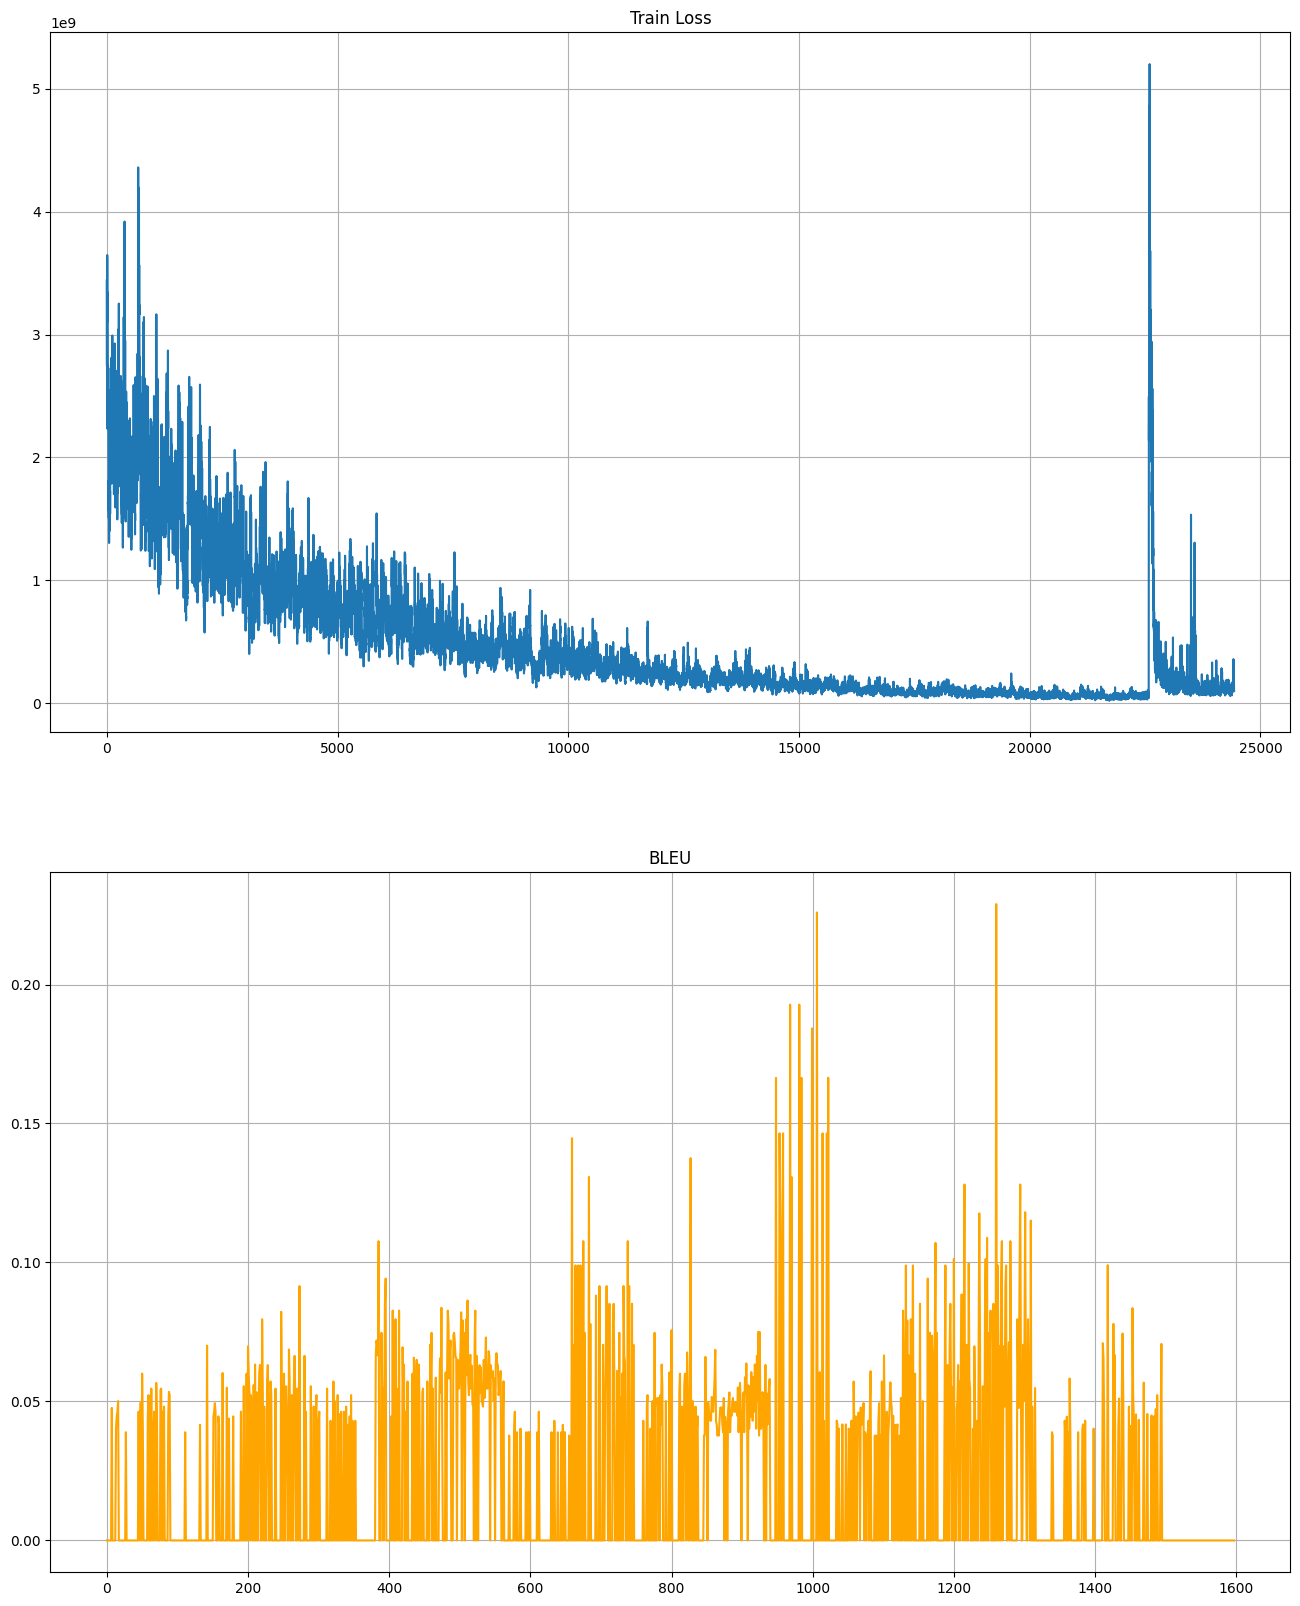

In [188]:
metrics = {'train_loss': [], 'dev_bleu': [] }
for epoch in range(epoches): 
    model = model.train()
    for data in tqdm(train_loader,desc = 'Эпоха '+str(epoch)):
        inp, out = data[0].to(device),data[1].to(device)
        loss = loss_function(model,inp,out)
#         print(metrics['train_loss'])
        loss.backward() 
        opt.step()
        opt.zero_grad()
        metrics['train_loss'].append(loss.cpu().detach().numpy())
#         print(metrics['train_loss'])
#         wandb.log({
#         "Epoch": epoch,
#         "Mean Train Loss": sum(loss_tr)/len(loss_tr),
#         "Train Acc": Acur(pred_tr,targ_tr),
#         "Learning rate": scheduler.get_last_lr()[0]})
    for data in tqdm(dev_loader,desc ='Эпоха валидация'+str(epoch)):
        inp, out = data[0],data[1]
#         inp = self.inp_voc.to_matrix(inp_lines).to(device)
#         initial_state = self.encode(inp)
#         out_ids, states = self.decode_inference(initial_state, **kwargs)
#         self.out_voc.to_lines(out_ids.cpu().numpy()), states
        bleu = compute_bleu(model,inp,out)
        metrics['dev_bleu'].append(bleu)
    clear_output()
    fig = plt.figure(figsize=(16,20))
    ax1,ax2 = fig.subplots(2,1)
    ax1.plot(metrics['train_loss'])
    ax1.grid()
    ax1.set_title('Train Loss')
    ax2.plot(metrics['dev_bleu'],color = 'orange')
    ax2.grid()
    ax2.set_title('BLEU')
    plt.show(block=True)

In [ ]:
<YOUR CODE: create AttentiveModel and training utilities>

In [ ]:
<YOUR CODE: training loop>

In [ ]:
<YOUR CODE: measure final BLEU>
    
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"y

In [ ]:
<YOUR CODE: print translate examples>

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [ ]:
from transformers import <YOUR CODE HERE>

tokenizer = <YOUR CODE HERE>
model = <YOUR CODE HERE>
# обычно есть How to Get Started With the Model и там показано, как инициализировать модель

In [ ]:
<YOUR CODE HERE: train loop>
# можно взять ваш из предыдущих пунктов

In [ ]:
<YOUR CODE HERE: compute_bleu>
# аналогично прошлым пунктам

assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 27, "Ты можешь больше! попробуй еще раз)"